Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-20 12:31:30.561609: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-20 12:31:30.561737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-04-20 12:31:31.007911: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-20 12:31:31.577843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 12:31:31.692692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 12:31:32.422427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 - 3s - loss: 0.0367 - 3s/epoch - 28ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0150 - 467ms/epoch - 5ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0121 - 485ms/epoch - 5ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0108 - 482ms/epoch - 5ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0095 - 470ms/epoch - 5ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0084 - 481ms/epoch - 5ms/step
Epoch 7/100
92/92 - 1s - loss: 0.0073 - 552ms/epoch - 6ms/step
Epoch 8/100
92/92 - 1s - loss: 0.0064 - 518ms/epoch - 6ms/step
Epoch 9/100
92/92 - 1s - loss: 0.0055 - 575ms/epoch - 6ms/step
Epoch 10/100
92/92 - 1s - loss: 0.0050 - 529ms/epoch - 6ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0046 - 498ms/epoch - 5ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0044 - 493ms/epoch - 5ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0043 - 490ms/epoch - 5ms/step
Epoch 14/100
92/92 - 1s - loss: 0.0044 - 514ms/epoch - 6ms/step
Epoch 15/100
92/92 - 1s - loss: 0.0042 - 511ms/epoch - 6ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0041 - 485ms/epoch - 5ms/step

2023-04-20 12:32:22.799983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-20 12:32:22.849755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 79ms/step
Train Score: 24.84 RMSE
Test Score: 60.98 RMSE


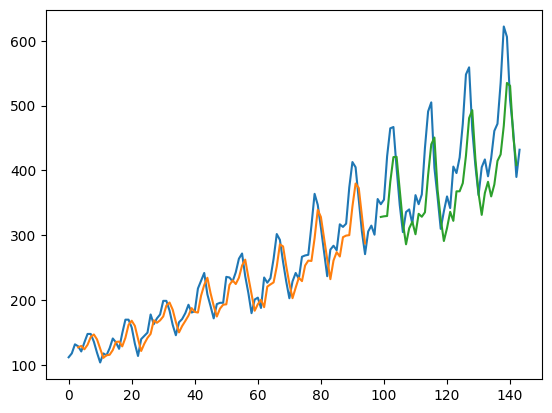

In [1]:
# LSTM for international airline passengers problem with time step regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('airline.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()